In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_root = "/content/drive/MyDrive/archive/LEVIR_CD/train/"
val_root   = "/content/drive/MyDrive/archive/LEVIR_CD/val/"
test_root  = "/content/drive/MyDrive/archive/LEVIR_CD/test/"


In [3]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class LEVIRCDDataset(Dataset):
    def __init__(self, root_dir):
        self.a_dir = os.path.join(root_dir, "A")
        self.b_dir = os.path.join(root_dir, "B")
        self.label_dir = os.path.join(root_dir, "label")
        self.filenames = sorted(os.listdir(self.a_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]

        # Görüntüleri oku
        imgA = cv2.imread(os.path.join(self.a_dir, fname))  # Zaman 1
        imgB = cv2.imread(os.path.join(self.b_dir, fname))  # Zaman 2
        label = cv2.imread(os.path.join(self.label_dir, fname), 0)  # grayscale değişim maskesi

        # Boyutlandırma (UNet için sabit boyut şart)
        imgA = cv2.resize(imgA, (256, 256))
        imgB = cv2.resize(imgB, (256, 256))
        label = cv2.resize(label, (256, 256))

        # Normalizasyon
        imgA = imgA.astype(np.float32) / 255.0
        imgB = imgB.astype(np.float32) / 255.0
        label = (label > 0).astype(np.float32)  # 0 veya 1

        # HWC → CHW dönüşümü
        imgA = np.transpose(imgA, (2, 0, 1))  # [3, H, W]
        imgB = np.transpose(imgB, (2, 0, 1))  # [3, H, W]

        # 6-kanallı giriş oluştur
        input_img = np.concatenate([imgA, imgB], axis=0)  # [6, H, W]

        return torch.tensor(input_img), torch.tensor(label).unsqueeze(0)  # [6, H, W], [1, H, W]


In [4]:
train_dataset = LEVIRCDDataset(train_root)
val_dataset = LEVIRCDDataset(val_root)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

# İlk batch'i test et
for batch in train_loader:
    images, masks = batch
    print(f"Girdi shape: {images.shape} | Maske shape: {masks.shape}")
    break


Girdi shape: torch.Size([4, 6, 256, 256]) | Maske shape: torch.Size([4, 1, 256, 256])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        super().__init__()

        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):

        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))


        b = self.bottleneck(self.pool4(e4))


        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        out = self.output(d1)
        return out


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
model = UNet(in_channels=6, out_channels=1).to(device)


In [10]:
import torch
import torch.nn as nn
from tqdm import tqdm


bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)


def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    targets = targets > 0.5

    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    accuracy = correct / total

    intersection = (preds & targets).float().sum()
    union = (preds | targets).float().sum()
    iou = intersection / (union + 1e-7)

    dice = (2 * intersection) / (preds.sum() + targets.sum() + 1e-7)

    return accuracy.item(), iou.item(), dice.item()


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = combined_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(dataloader)


def validate_one_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_acc, total_iou, total_dice = 0.0, 0.0, 0.0
    count = 0

    pbar = tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for inputs, targets in pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = combined_loss(outputs, targets)
            total_loss += loss.item()

            acc, iou, dice = compute_metrics(outputs, targets)
            total_acc += acc
            total_iou += iou
            total_dice += dice
            count += 1

            pbar.set_postfix(loss=loss.item(), iou=iou, dice=dice)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / count
    avg_iou = total_iou / count
    avg_dice = total_dice / count

    return avg_loss, avg_acc, avg_iou, avg_dice


num_epochs = 20
best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc, val_iou, val_dice = validate_one_epoch(model, val_loader, device)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Yeni en iyi model kaydedildi.")



Epoch 1/20
Train Loss: 0.4472 | Val Loss: 0.4272
Val Acc: 0.9779 | IoU: 0.5855 | Dice: 0.7348
✅ Yeni en iyi model kaydedildi.



Epoch 2/20
Train Loss: 0.4134 | Val Loss: 0.4055
Val Acc: 0.9708 | IoU: 0.5628 | Dice: 0.7144
✅ Yeni en iyi model kaydedildi.



Epoch 3/20
Train Loss: 0.3827 | Val Loss: 0.3894
Val Acc: 0.9781 | IoU: 0.5797 | Dice: 0.7273
✅ Yeni en iyi model kaydedildi.



Epoch 4/20
Train Loss: 0.3572 | Val Loss: 0.3451
Val Acc: 0.9784 | IoU: 0.6233 | Dice: 0.7632
✅ Yeni en iyi model kaydedildi.



Epoch 5/20
Train Loss: 0.3339 | Val Loss: 0.3325
Val Acc: 0.9817 | IoU: 0.6434 | Dice: 0.7788
✅ Yeni en iyi model kaydedildi.



Epoch 6/20
Train Loss: 0.3142 | Val Loss: 0.3079
Val Acc: 0.9819 | IoU: 0.6525 | Dice: 0.7842
✅ Yeni en iyi model kaydedildi.



Epoch 7/20
Train Loss: 0.2905 | Val Loss: 0.2928
Val Acc: 0.9835 | IoU: 0.6754 | Dice: 0.8033
✅ Yeni en iyi model kaydedildi.



Epoch 8/20
Train Loss: 0.2759 | Val Loss: 0.2962
Val Acc: 0.9797 | IoU: 0.6375 | Dice: 0.7740



Epoch 9/20
Train Loss: 0.2691 | Val Loss: 0.3219
Val Acc: 0.9809 | IoU: 0.6004 | Dice: 0.7443



Epoch 10/20
Train Loss: 0.2527 | Val Loss: 0.2731
Val Acc: 0.9833 | IoU: 0.6542 | Dice: 0.7869
✅ Yeni en iyi model kaydedildi.



Epoch 11/20
Train Loss: 0.2405 | Val Loss: 0.2643
Val Acc: 0.9821 | IoU: 0.6609 | Dice: 0.7894
✅ Yeni en iyi model kaydedildi.



Epoch 12/20
Train Loss: 0.2319 | Val Loss: 0.2704
Val Acc: 0.9804 | IoU: 0.6412 | Dice: 0.7746



Epoch 13/20
Train Loss: 0.2138 | Val Loss: 0.2537
Val Acc: 0.9836 | IoU: 0.6826 | Dice: 0.8073
✅ Yeni en iyi model kaydedildi.



Epoch 14/20
Train Loss: 0.2049 | Val Loss: 0.2415
Val Acc: 0.9855 | IoU: 0.6987 | Dice: 0.8187
✅ Yeni en iyi model kaydedildi.



Epoch 15/20
Train Loss: 0.2006 | Val Loss: 0.2451
Val Acc: 0.9854 | IoU: 0.6836 | Dice: 0.8075



Epoch 16/20
Train Loss: 0.1956 | Val Loss: 0.2374
Val Acc: 0.9857 | IoU: 0.7010 | Dice: 0.8204
✅ Yeni en iyi model kaydedildi.



Epoch 17/20
Train Loss: 0.1899 | Val Loss: 0.2707
Val Acc: 0.9820 | IoU: 0.6247 | Dice: 0.7635



Epoch 18/20
Train Loss: 0.1877 | Val Loss: 0.2313
Val Acc: 0.9853 | IoU: 0.7002 | Dice: 0.8193
✅ Yeni en iyi model kaydedildi.



Epoch 19/20
Train Loss: 0.1741 | Val Loss: 0.2318
Val Acc: 0.9859 | IoU: 0.7132 | Dice: 0.8294



Epoch 20/20
Train Loss: 0.1754 | Val Loss: 0.2193
Val Acc: 0.9866 | IoU: 0.7163 | Dice: 0.8313
✅ Yeni en iyi model kaydedildi.


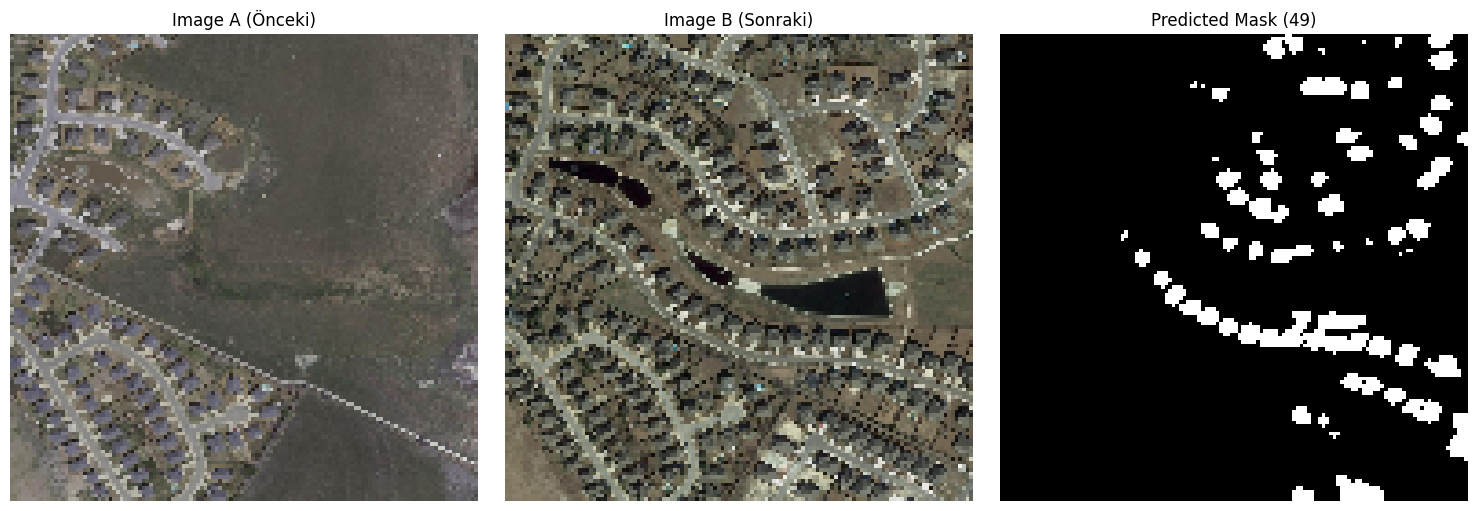

In [19]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

sample_name = "test_49.png"
sample_id = os.path.splitext(sample_name)[0].split("_")[-1]


test_root = "/content/drive/MyDrive/archive/LEVIR_CD/test/"
a_path = os.path.join(test_root, "A", sample_name)
b_path = os.path.join(test_root, "B", sample_name)


imgA = cv2.imread(a_path)
imgB = cv2.imread(b_path)

if imgA is None or imgB is None:
    raise FileNotFoundError(f"Görüntü okunamadı: {a_path} veya {b_path}")


size = (128, 128)
imgA = cv2.resize(imgA, size)
imgB = cv2.resize(imgB, size)


imgA_norm = imgA.astype(np.float32) / 255.0
imgB_norm = imgB.astype(np.float32) / 255.0
imgA_norm = np.transpose(imgA_norm, (2, 0, 1))
imgB_norm = np.transpose(imgB_norm, (2, 0, 1))
input_tensor = np.concatenate([imgA_norm, imgB_norm], axis=0)
input_tensor = torch.tensor(input_tensor).unsqueeze(0).to(device)


model = UNet(in_channels=6, out_channels=1).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()


with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255


overlay = cv2.addWeighted(imgB, 0.7, cv2.cvtColor(pred_mask_bin, cv2.COLOR_GRAY2BGR), 0.3, 0)


mask_filename = f"predicted_mask_{sample_id}.png"
overlay_filename = f"overlay_result_{sample_id}.png"

cv2.imwrite(mask_filename, pred_mask_bin)
cv2.imwrite(overlay_filename, overlay)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Image A (Önceki)")
plt.imshow(cv2.cvtColor(imgA, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Image B (Sonraki)")
plt.imshow(cv2.cvtColor(imgB, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Predicted Mask ({sample_id})")
plt.imshow(pred_mask_bin, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
